In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
import joblib
from pprint import pprint
from math import ceil
import imodelsx.util
import sasc.viz
import pickle as pkl
import json
from copy import deepcopy
from numpy.linalg import norm
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import normalize
from PIL import Image
import img2pdf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
from copy import deepcopy
import joblib
from pprint import pprint
from math import ceil
import cortex
from neuro.config import repo_dir, PROCESSED_DIR, setup_freesurfer
from collections import defaultdict
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import gemv
from neuro.flatmaps_helper import load_flatmaps
import sasc.viz
from neuro import analyze_helper
import nibabel as nib
neurosynth_compare = __import__('04_neurosynth_compare')
import neurosynth
from neuro.features.questions.gpt4 import QS_35_STABLE
import viz
setup_freesurfer()
from sasc.config import CACHE_DIR, RESULTS_DIR, cache_ngrams_dir, regions_idxs_dir, FMRI_DIR, SAVE_DIR_FMRI
import sasc.modules.fmri_module

In [47]:
def _get_35q_weights(subject):
    d = defaultdict(list)
    setting = 'individual_gpt4_ndel=1_pc_new'
    flatmaps_qa_dict = joblib.load(
        join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
    flatmaps_qa_list = [
        flatmaps_qa_dict[q] for q in QS_35_STABLE
    ]
    weights_arr_to_cluster = np.vstack(flatmaps_qa_list)
    return weights_arr_to_cluster


def _get_llama_weights(subject):
    mod = sasc.modules.fmri_module.fMRIModule(
        subject=f"UT{subject}",
        # checkpoint="facebook/opt-30b",
        checkpoint="huggyllama/llama-30b",
        init_model=False,
        restrict_weights=False,
    )
    weights_arr_full = mod.weights
    # weights_arr_full has shape (num_delays x num_linear_coefs, num_voxels)
    weights_arr_to_cluster = weights_arr_full.reshape(
        4, -1, weights_arr_full.shape[1]).mean(axis=0)
    return weights_arr_to_cluster


def compute_explained_variance(X, sparse_pca):
    """
    Compute the explained variance of SparsePCA components.

    Parameters:
    X (numpy array): The original data matrix.
    sparse_pca (SparsePCA object): A fitted SparsePCA model.

    Returns:
    explained_variance (numpy array): Variance explained by each component.
    explained_variance_ratio (numpy array): Ratio of variance explained by each component.
    """
    # Transform data using Sparse PCA
    X_transformed = sparse_pca.transform(X)  # (n_samples, n_components)

    # Compute variance explained by each component
    n_samples = X.shape[0]
    explained_variance = np.var(
        X_transformed, axis=0) * (n_samples - 1) / n_samples

    # Compute total variance of the original data
    total_variance = np.var(X, axis=0).sum()

    # Compute explained variance ratio
    explained_variance_ratio = explained_variance / total_variance

    return explained_variance, explained_variance_ratio


subject = 'S03'
# setting = 'llama'
setting = '35q'
# sparse = ''
sparse = '_sparse'
num_pcs = 4
pc_dir = join('pca', subject)
os.makedirs(pc_dir, exist_ok=True)

SETTINGS = [
    ('35q', '', None),
    ('llama', '', None),
    ('35q', '_sparse', 10),
    ('35q', '_sparse', 20),
    ('35q', '_sparse', 25),
    ('35q', '_sparse', 30),
    # ('35q', '_sparse', 100),
]

for setting, sparse, alpha in SETTINGS:
    if setting == 'llama':
        weights_arr_to_cluster = _get_llama_weights(subject)
    elif setting == '35q':
        weights_arr_to_cluster = _get_35q_weights(subject)

    # pca
    if sparse == '':
        pca = PCA(n_components=num_pcs, whiten=True)
    elif sparse == '_sparse':
        pca = SparsePCA(n_components=num_pcs, alpha=alpha)
    if alpha is None:
        alpha_suffix = ''
    else:
        alpha_suffix = f'_alpha{alpha}'

    X = weights_arr_to_cluster.T
    X_normalized = normalize(X)
    pca.fit(X_normalized)
    if sparse == '_sparse':
        explained_variance, explained_variance_ratio = compute_explained_variance(
            X_normalized, pca)
        pca.explained_variance_ = explained_variance
        pca.explained_variance_ratio_ = explained_variance_ratio
    print('frac zero', np.mean(pca.components_ == 0))
    # pca.components_.shape is (num_pcs, num_linear_coefs)
    # pc_coefs_per_voxel.shape is (num_voxels, num_pcs)
    pc_coefs_per_voxel = pca.transform(X_normalized)

    joblib.dump({'pc_coefs_per_voxel': pc_coefs_per_voxel,
                'pca': pca}, join(pc_dir, f'pca{sparse}_{setting}{alpha_suffix}_coefs.pkl'))

frac zero 0.0
initializing fmri...


/home/chansingh/.env/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


frac zero 0.0
frac zero 0.6285714285714286
frac zero 0.8285714285714286
frac zero 0.9071428571428571
frac zero 0.9357142857142857


In [49]:
corrs_test = joblib.load(join(PROCESSED_DIR, subject.replace(
    'UT', ''), 'corrs_test_35.pkl')).values[0]
mask = corrs_test < 0.1


fnames = sorted([join(pc_dir, f)
                for f in os.listdir(pc_dir) if f.endswith('.pkl')])
print(fnames)
coefs_dict = {}
for k in fnames:
    coefs_dict[k] = joblib.load(k)


# align sign of comps
fname_gt = join(pc_dir, 'pca_llama_coefs.pkl')
coef_gt = coefs_dict[fname_gt]['pc_coefs_per_voxel']

# try to make flatmaps show positive regions
k = fname_gt
for pc_num in range(coef_gt.shape[1]):
    avg_val = np.mean(coef_gt[:, pc_num][~mask])
    if avg_val < 0:
        coefs_dict[k]['pc_coefs_per_voxel'][:, pc_num] *= -1
        coefs_dict[k]['pca'].components_[pc_num] *= -1

# align other coefs to gt
for k in coefs_dict:
    corrs = []
    for pc_num in range(coef_gt.shape[1]):
        corr = np.corrcoef(
            coefs_dict[k]['pc_coefs_per_voxel'][:, pc_num],
            coefs_dict[fname_gt]['pc_coefs_per_voxel'][:, pc_num])[0, 1]
        if corr < 0:
            coefs_dict[k]['pc_coefs_per_voxel'][:, pc_num] *= -1
            coefs_dict[k]['pca'].components_[pc_num] *= -1
        corrs.append(corr)
    # print(k, np.abs(corrs).round(2))

# # visualize
for k in tqdm(coefs_dict):
    # save plots
    for i in range(num_pcs):
        flatmap = coefs_dict[k]['pc_coefs_per_voxel'][:, i]
        flatmap[mask] = np.nan
        sasc.viz.quickshow(
            flatmap, subject, fname_save=join(pc_dir, f'pca_{i+1}.png'), kwargs={'with_curvature': True})

    # read all plots and save as subplots on the same page
    fig, axs = plt.subplots(1, 4, figsize=(12, 2.5))
    axs = axs.ravel()
    for i in range(num_pcs):
        axs[i].imshow(Image.open(join(pc_dir, f'pca_{i+1}.png')))
        axs[i].axis('off')
        exp_var_ratio = coefs_dict[k]['pca'].explained_variance_ratio_[i]
        axs[i].set_title(f'PC {i + 1} ({exp_var_ratio:.2f})')
        # axs[i].set_title(f'PC {i + 1}')
    plt.tight_layout()

    plt.savefig(k.replace('.pkl', '_subplots.png'), transparent=True)
    plt.close()

['pca/S03/pca_35q_coefs.pkl', 'pca/S03/pca_llama_coefs.pkl', 'pca/S03/pca_sparse_35q_alpha10_coefs.pkl', 'pca/S03/pca_sparse_35q_alpha20_coefs.pkl', 'pca/S03/pca_sparse_35q_alpha25_coefs.pkl', 'pca/S03/pca_sparse_35q_alpha30_coefs.pkl']


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:44<00:00, 27.45s/it]


/tmp/ipykernel_1114488/3716915927.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


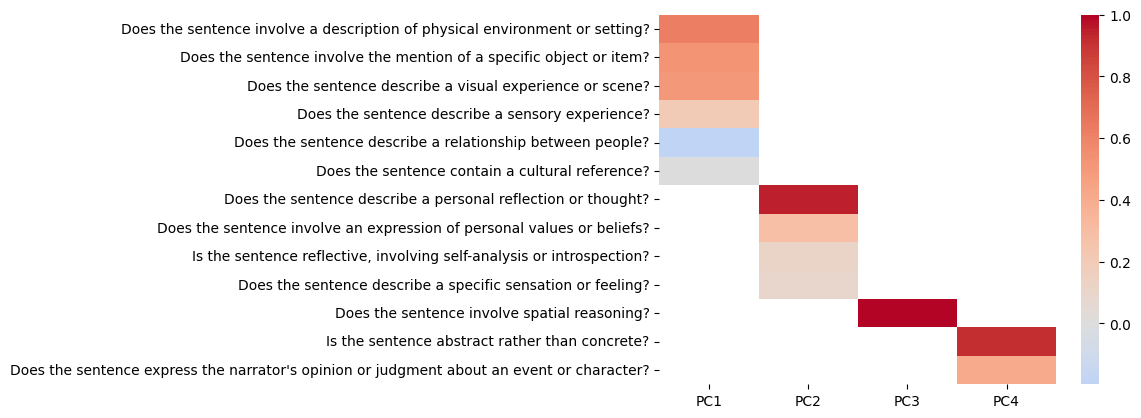

In [51]:
# fname = 'pca_35q_coefs.pkl'
# fname = 'pca_sparse_35q_alpha20_coefs.pkl'
fname = 'pca_sparse_35q_alpha25_coefs.pkl'
# fname = 'pca_sparse_35q_alpha30_coefs.pkl'
fname = join(pc_dir, fname)
pcs = pd.DataFrame(coefs_dict[fname]['pca'].components_).T
pcs.columns = [f'PC{i+1}' for i in range(pcs.shape[1])]
pcs.index = QS_35_STABLE

# drop rows that are all zero
pcs = pcs.loc[(pcs != 0).any(axis=1)]

# sort values by abs value of PC1 then PC2 then PC3 then PC4
a = pcs.abs().sort_values(
    by=['PC1', 'PC2', 'PC3', 'PC4'], ascending=False).index
pcs = pcs.loc[a]
sns.heatmap(pcs, cmap='coolwarm', center=0, mask=pcs == 0)

# plt.figure(figsize=(10, 10))
# pcs = pcs.sort_values(
#     by=['PC1', 'PC2', 'PC3', 'PC4'], ascending=False)
# sns.heatmap(pcs, cmap='coolwarm', center=0, mask=pcs == 0)

# sns.clustermap(pcs, col_cluster=False, cmap='coolwarm',
#    center=0, mask=pcs == 0)
plt.tight_layout()
plt.savefig(join(pc_dir, 'pc_loadings.png'), transparent=True,
            dpi=300, bbox_inches='tight')
plt.show()

### 3d colormaps

In [ ]:
import cortex
import numpy as np

# Load a sample subject
subject = "UTS02"  # Change this to your actual subject ID
xfmname = "UTS02_auto"  # Change based on your transformation

# Generate three example maps (replace with real data)
volume_shape = flatmap.shape
map1 = pc_coefs_per_voxel[:, 0]
map2 = pc_coefs_per_voxel[:, 1]
map3 = pc_coefs_per_voxel[:, 2]

# Normalize each map to be in range [0,1]
map1 = (map1 - map1.min()) / (map1.max() - map1.min())
map2 = (map2 - map2.min()) / (map2.max() - map2.min())
map3 = (map3 - map3.min()) / (map3.max() - map3.min())

# Create a 3-channel RGB volume
rgb_volume = cortex.VolumeRGB(
    map1, map2, map3, subject=subject, xfmname=xfmname)

# Show the visualization
cortex.quickshow(rgb_volume)